Collaborative Filtering Course Recommender
---
Apart from our standard course recommender which maps the student query with the course description / learning objectives of courses from our database, we also implement a collaborative filtering based course recommender based on the actual student feedback we acquired, so that our course recommender's performance can be further improved.

The dataset we will use for training this collaborative filtering based course recommender is the feedback dataset we acquired by asking HKU students to test our program for two days.

The flow of this Jupyter notebook is as follows:
1. Feedback Data Preprocessing
2. Evaluation of our previous standard course recommender
3. Training of the new Collaborativ Filtering Course Recommender
4. Evaluation of the new Collaboratively Filtering Course Recommender

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Feedback Data Preprocessing
We collected student feedback on our existing standard recommender by interviewing students at HKU for two days. Here we first clean the feedback dataset.

In [3]:
# read the raw recommender feedback dataset
df_feedback = pd.read_csv('data/recommendations_feedback.csv', index_col=0)

In [4]:
'''
delete all the unnecssary rows that:
1. does not come from a student, or 
2. does not contain any rating/precision_count, or
3. does not have a recommender rec type of 'course', or
4. contains duplicate usernames
'''
df_feedback = df_feedback.loc[~df_feedback['user_email'].isin(['rocky', 'rocky2'])]
df_feedback = df_feedback.dropna()
df_feedback = df_feedback.loc[df_feedback['recommender_rec_type'] == 'course']
df_feedback = df_feedback.drop(index=217)
df_feedback = df_feedback.reset_index(drop=True)

In [5]:
# print length of the dataset
len(df_feedback)

112

In [6]:
# save the preprocessed dataset to local
df_feedback.to_csv('data/recommendations_feedback_preprocessed.csv')

# 2. Evaluation of Previous Standard Recommender
Since this student feedback dataset was collected based on students' ratings on our **standard recommender model** - one that matches the student query with each course's description/learning outcomes - we will first use the data to evaluate our previous/existing standard recommender before training a new collaborative filtering based recommender.

There were 2 useful attributes and using each of them we can calculate a series of scores:
1. **Rating** from 1 (lowest) to 5 (highest)
    - Average testing score
2. **Precision Count** from 0 to 5
    - P@K (precision at K)
    - AP@K (average precision at K)
    - MAP@K (mean average precision at K)

## 2.1 Average testing score
We will be using all 114 rows of the feedback dataset as testing data for our previous/existing standard recommender. Since each score ranges from 1 to 5, we will calculate the average score between 1 and 5.

In [7]:
# calculate the average rating
ratings = df_feedback['rating']
avg_rating = np.mean(ratings)

In [8]:
# print the average rating as a score between 1 and 5
print(f'The average rating of the testing dataset is: {avg_rating}')

The average rating of the testing dataset is: 3.455357142857143


In [9]:
# print the average rating as a percentage
print(f'The average rating of the testing dataset in percentage is: {round(avg_rating/5*100, 2)}%')

The average rating of the testing dataset in percentage is: 69.11%


## 2.2 P@5 (Precision at 5) / AP@K (Average Precision at 5)
We will be using the **precision count** data collected to calculate P@5, which represents the number of relevant items that are present in our top-5 recommendations using our standard recommender. But since each user only rates the recommendations once, P@5 in our case is the same as AP@5 for each user.

In [11]:
# calculate P@5/AP@5
precision_counts = df_feedback['precision_count']
print(f'The P@5/AP@5 score for each user is as follows:\n{precision_counts}')

The P@5/AP@5 score for each user is as follows:
0      5.0
1      0.0
2      4.0
3      4.0
4      4.0
      ... 
107    2.0
108    4.0
109    1.0
110    3.0
111    2.0
Name: precision_count, Length: 112, dtype: float64


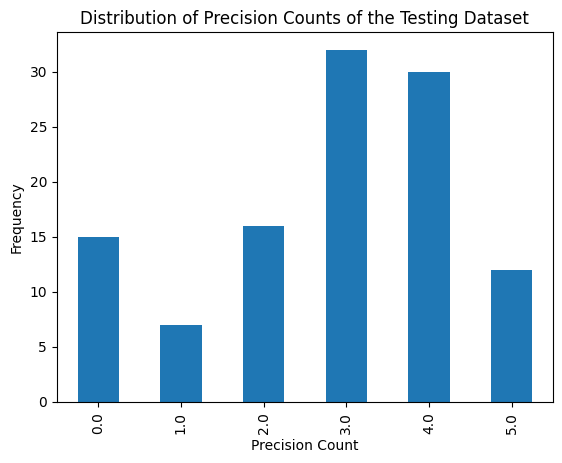

In [28]:
# (for further understanding on the result) plot distribution of precision counts
df_feedback.groupby('precision_count').size().plot(kind='bar')
plt.title('Distribution of Precision Counts of the Testing Dataset')
plt.xlabel('Precision Count')
plt.ylabel('Frequency')
plt.show()

## 2.3 MAP@5 (Mean Average Precision at 5)
Now we calculate the mean average precision at 5 by averaging the precision counts over all users.

In [12]:
# calculate MAP@5
map_at_5 = np.mean(precision_counts)

In [13]:
# print MAP@5
print(f'The MAP@5 score of the testing dataset is: {map_at_5}')

The MAP@5 score is: 2.8125


In [14]:
# print MAP@5 as a percentage
print(f'The MAP@5 score of the testing dataset in percentage is: {round(map_at_5/5*100, 2)}%')

The MAP@5 score of the testing dataset in percentage is: 56.25%


## Conclusion on Section 2
It is clear that although the average testing score of our previous/existing standard recommender is at an acceptable level of around 70%, our MAP@5 performs much worse at around 56%. Therefore, we will need to improve on this standard model.

# 3. Training of the new Collaborative Filtering Course Recommender
For our new collaborative filtering based course recommender, we will implement the following steps. Our algorithm follows the user-based collaborative filtering method:
1. For each user, we will find similar other users based on the query / user profile.
2. Suggest other highly rated courses based on the preferences of these similar users.

Step 1 is different from conventional user-based CF recommenders. Here instead of using the ratings to find the most similar users/neighbors for the target user, we use NLP and a cluster algorithm to find the neighbors.

## 3.1 Data Preprocessing
We will first need to preprocess the 'recommendations_feedback_with_individual_ratings.csv' dataset.

### 3.1.1 Raw Dataset

In [77]:
# read the feedback dataset containing individual course ratings
df = pd.read_csv('data/recommendations_feedback_with_individual_ratings.csv', index_col=0)

In [78]:
# extract the useful columns: 'user_email', 'user_query', 'result', 'rating'
df_useful = df[[
    'user_email', 'actual_string', 'result', 'rating'
]].reset_index(drop=True)

In [79]:
# process the 'actual_string' column
df_useful['actual_string'] = df_useful['actual_string'].apply(lambda x: x.strip('; '))

In [80]:
df_useful

,user_email,actual_string,result,rating
0,sudairi,courses computer AI,COMP2396B: Object-oriented Programming and Java,3
1,sudairi,courses computer AI,COMP2396A: Object-oriented Programming and Jav...,3
2,sudairi,courses computer AI,COMP3270A: Artificial Intelligence,5
3,sudairi,courses computer AI,COMP3270B: Artificial Intelligence,5
4,sudairi,courses computer AI,COMP2120A: Computer Organization (CS),3
...,...,...,...,...
555,121,"I want to learn about agriculture production, ...",BIOL4415: Healthcare biotechnology,4
556,121,"I want to learn about agriculture production, ...",BIOL3303: Conservation biology,2
557,121,"I want to learn about agriculture production, ...",BIOL3508: Microbial physiology and biotechnology,2
558,121,"I want to learn about agriculture production, ...",BIOL3608: Food commodities,4


In [81]:
# save the dataset to local
df_useful.to_csv('data/recommendations_feedback_preprocessed_with_individual_ratings.csv')

### 3.1.2 Query Conversion to Word Embeddings
We will be using the pretrained 'google-news-300' model to convert the student queries into word embeddings.

In [82]:
from gensim.models import KeyedVectors

In [83]:
# load the prtrained model from local
w2v = KeyedVectors.load('models/w2v_google_news_300.model')

In [84]:
# preprocess the input into tokenized words and save it in the dataframe
from packages.preprocess import preprocess
df_useful['tokenized'] = df_useful['actual_string'].apply(lambda x: preprocess(x))

In [85]:
# get word embeddings for each row of the dataframe
from packages.preprocess import get_word_embeddings
df_useful['embeddings'] = df_useful['actual_string'].apply(lambda x: get_word_embeddings(x, w2v))

### 3.1.3 Training & Testing Data

In [91]:
# split the dataset into training and testing data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_useful, shuffle=True, random_state=7600, test_size=0.2)

In [92]:
print(f'Training dataset size: {len(df_train)}\nTesting dataset size: {len(df_test)}')

Training dataset size: 448
Testing dataset size: 112


## 3.2 Step 1 - Find Neighbors to Target User
We will be considering the kNN algorithm to identify top N neighbors to the target user.

In [120]:
# identify the training and testing datasets for the word embeddings
X_train = np.array(df_train['embeddings'].apply(lambda x: list(x)).tolist())
X_test = np.array(df_test['embeddings'].apply(lambda x: list(x)).tolist())

print(f'Shape of X_train: {X_train.shape}\nShape of X_test: {X_test.shape}')

Shape of X_train: (448, 300)
Shape of X_test: (112, 300)


In [121]:
# define N (the number of neighbors)
N=10

In [123]:
# define the knn model
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=N, metric='cosine')

In [124]:
# fit the knn model on the training set
knn.fit(X_train)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [186]:
# save the knn model to local
from joblib import dump
dump(knn, 'models/collaborative_filtering_neighbors_knn.joblib')

['models/collaborative_filtering_neighbors_knn.joblib']

### 3.2.1 Find Top N Neighbors for the Training Set

In [205]:
# find the top N neighbors (index) for the training set
df_train_neighbors_distances, df_train_neighbors = knn.kneighbors(X_train, return_distance=True)
print(df_train_neighbors)
print(df_train_neighbors_distances)

[[432   0 271 ... 399 104 311]
 [414 409 311 ... 104 290 399]
 [  2 213  85 ... 134  21 379]
 ...
 [445 376 161 ... 379  73  50]
 [438 229 446 ... 131 235 141]
 [330 366 248 ... 137 285 240]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.0242372e-01
  3.0242401e-01 6.7731690e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.6659117e-01
  6.6659129e-01 6.6659129e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.1248885e-01
  3.1248885e-01 3.1248885e-01]
 ...
 [0.0000000e+00 0.0000000e+00 1.7881393e-07 ... 2.4899644e-01
  4.3432152e-01 4.3432152e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.4306127e-01
  4.4610232e-01 4.4610232e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.5802338e-01
  3.1130099e-01 3.1130099e-01]]


In [206]:
# add a new column called 'neighbors' and another column called 'neighbors_distances' to the df_train dataset
df_train['neighbors'] = df_train_neighbors.tolist()
df_train['neighbors_distances'] = df_train_neighbors_distances.tolist()
df_train.head(2)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_email,actual_string,result,rating,tokenized,embeddings,neighbors,neighbors_users,neighbors_distances
480,104,credit analyst,STAT4903: Actuarial techniques for general ins...,2,"[credit, analyst]","[0.05279541, 0.061035156, -0.010528564, 0.1579...","[432, 0, 271, 276, 395, 387, 290, 399, 104, 311]","[94, sudairi, 62, 63, 87, 85, 66, 87, 19, 70]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.30242371559143066,..."
63,10,investment,STAT3618: Derivatives and risk management,4,[investment],"[-0.0071105957, 0.032958984, 0.057861328, -0.1...","[414, 409, 311, 1, 197, 308, 133, 104, 290, 399]","[90, 89, 70, sudairi, 46, 69, 32, 19, 66, 87]","[0.0, 0.0, 0.0, 0.0, 0.6318032741546631, 0.631..."


In [207]:
# find the corresponding 10 neighbor user emails for each test case
df_train_neighbors_users = [df_useful.loc[neighbors]['user_email'].values.tolist() for neighbors in df_train_neighbors]
df_train_neighbors_users

[['94', 'sudairi', '62', '63', '87', '85', '66', '87', '19', '70'],
 ['90', '89', '70', 'sudairi', '46', '69', '32', '19', '66', '87'],
 ['sudairi', '50', '15', '89', '76', '88', '43', '32', '1', '83'],
 ['fee', '5', '10', '43', '66', '84', '36', 'sudairi', '15', '68'],
 ['sudairi', '17', '13', '96', '75', '76', '79', '82', '58', '19'],
 ['fee', '27', '83', '77', '40', '63', '31', '61', '87', '42'],
 ['fee', '35', '11', '71', '15', '75', '37', '11', 'Max', '4'],
 ['39', '16', 'fee', '91', '46', '65', '28', '65', '57', 'Max'],
 ['54', '62', '62', 'fee', '59', '12', '36', '41', '24', '50'],
 ['fee', '5', '10', '43', '66', '84', '36', 'sudairi', '89', '61'],
 ['Max', '85', '59', '87', '6', '61', '82', '70', '27', '38'],
 ['75', 'Max', '11', '37', 'fee', '11', '15', '35', '71', '75'],
 ['85', '91', 'Max', '51', '90', '41', '72', '69', '73', '68'],
 ['Max', '48', '19', '38', '46', '77', '56', '14', '16', '17'],
 ['94', '59', 'Max', '13', '93', '81', '63', '58', '74', '8'],
 ['kiki', '33', '

In [208]:
# add a new column called 'neighbors_users' to the df_test dataset
df_train['neighbors_users'] = df_train_neighbors_users
df_train.head(2)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_email,actual_string,result,rating,tokenized,embeddings,neighbors,neighbors_users,neighbors_distances
480,104,credit analyst,STAT4903: Actuarial techniques for general ins...,2,"[credit, analyst]","[0.05279541, 0.061035156, -0.010528564, 0.1579...","[432, 0, 271, 276, 395, 387, 290, 399, 104, 311]","[94, sudairi, 62, 63, 87, 85, 66, 87, 19, 70]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.30242371559143066,..."
63,10,investment,STAT3618: Derivatives and risk management,4,[investment],"[-0.0071105957, 0.032958984, 0.057861328, -0.1...","[414, 409, 311, 1, 197, 308, 133, 104, 290, 399]","[90, 89, 70, sudairi, 46, 69, 32, 19, 66, 87]","[0.0, 0.0, 0.0, 0.0, 0.6318032741546631, 0.631..."


### 3.2.2 Find Top N Neighbors fo the Testing Set

In [209]:
# find the top N neighbors (index) for the testing set
df_test_neighbors_distances, df_test_neighbors = knn.kneighbors(X_test, return_distance=True)

In [210]:
# add a new column called 'neighbors' to the df_test dataset
df_test['neighbors'] = df_test_neighbors.tolist()
df_test['neighbors_distances'] = df_test_neighbors_distances.tolist()
df_test.head(2)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_email,actual_string,result,rating,tokenized,embeddings,neighbors,neighbors_users,neighbors_distances
42,6,i desire biology,SCNC1112: Fundamentals of modern science,5,"[desire, biology]","[0.07080078, 0.1574707, -0.009765625, 0.149169...","[75, 14, 256, 434, 30, 67, 367, 429, 275, 334]","[13, Max, 59, 94, 4, 11, 81, 93, 63, 74]","[0.0, 0.0, 0.0, 0.0, 0.22813677787780762, 0.22..."
179,42,"financial time series modeling, stochastic cal...",COMP2121A: Discrete Mathematics (CS),3,"[financial, time, series, modeling, stochastic...","[-0.0230306, 0.02319336, -0.10100301, 0.123311...","[377, 360, 296, 341, 338, 358, 370, 55, 340, 286]","[83, 80, 67, 76, 75, 79, 82, 9, 76, 65]","[0.0, 0.0, 0.0, 0.36456453800201416, 0.3645645..."


In [211]:
# find the corresponding 10 neighbor user emails for each test case
df_test_neighbors_users = [df_useful.loc[neighbors]['user_email'].values.tolist() for neighbors in df_test_neighbors]
df_test_neighbors_users

[['13', 'Max', '59', '94', '4', '11', '81', '93', '63', '74'],
 ['83', '80', '67', '76', '75', '79', '82', '9', '76', '65'],
 ['74', '68', '46', '41', '47', '24', '36', '47', '19', '38'],
 ['50', '58', '95', '27', '35', '71', '11', '15', 'fee', '3'],
 ['9', '31', '9', '10', '10', '86', '43', '8', '59', '12'],
 ['46', '77', '56', 'Max', '48', '38', '19', '82', '79', '76'],
 ['93', '95', '47', '13', '41', '82', '38', '81', '57', 'kiki'],
 ['97', '83', '42', '39', '32', '1', '83', '43', '58', '17'],
 ['76', '32', '75', '16', '75', 'Max', '37', '11', '14', '77'],
 ['kiki', '78', '93', '84', '75', '39', '77', '4', '48', '54'],
 ['12', '59', '36', '41', '24', '62', '62', '54', 'fee', '57'],
 ['92', '37', '12', '90', '96', '86', '82', '65', '28', '65'],
 ['32', '1', '83', '43', '97', '42', '83', '39', '89', '15'],
 ['8', '44', '5', '60', '38', '82', '41', '1', '3', '86'],
 ['67', '45', '86', '87', '6', '61', '70', '82', '38', '27'],
 ['12', '37', '92', '82', '86', '90', '96', '65', '28', '65'

In [212]:
# add a new column called 'neighbors_users' to the df_test dataset
df_test['neighbors_users'] = df_test_neighbors_users
df_test.head(2)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_email,actual_string,result,rating,tokenized,embeddings,neighbors,neighbors_users,neighbors_distances
42,6,i desire biology,SCNC1112: Fundamentals of modern science,5,"[desire, biology]","[0.07080078, 0.1574707, -0.009765625, 0.149169...","[75, 14, 256, 434, 30, 67, 367, 429, 275, 334]","[13, Max, 59, 94, 4, 11, 81, 93, 63, 74]","[0.0, 0.0, 0.0, 0.0, 0.22813677787780762, 0.22..."
179,42,"financial time series modeling, stochastic cal...",COMP2121A: Discrete Mathematics (CS),3,"[financial, time, series, modeling, stochastic...","[-0.0230306, 0.02319336, -0.10100301, 0.123311...","[377, 360, 296, 341, 338, 358, 370, 55, 340, 286]","[83, 80, 67, 76, 75, 79, 82, 9, 76, 65]","[0.0, 0.0, 0.0, 0.36456453800201416, 0.3645645..."


## 3.3 Step 2 - Recommend Items based on Top N Neighbors

In [213]:
# create user-course matrix for the training dataset
df_train_matrix = df_train.pivot_table(index='user_email', columns='result', values='rating')
df_train_matrix.head()

result,APAI3021: Modern biostatistics,BIOC2600: Basic biochemistry,BIOC4613: Advanced techniques in biochemistry & molecular biology,BIOL1110: From molecules to cells,BIOL1201: Introduction to food and nutrition,BIOL3109: Environmental and molecular ecology,BIOL3203: Food microbiology,BIOL3204: Nutrition and the life cycle,BIOL3209: Food and nutrient analysis,BIOL3303: Conservation biology,...,STAT3617: Sample survey methods,STAT3618: Derivatives and risk management,STAT3622: Data visualization,STAT3906: Risk theory I,STAT4603: Current topics in risk management,STAT4608: Market risk analysis,STAT4609: Big data analytics,STAT4767: Actuarial science internship,STAT4798: Statistics and actuarial science project,STAT4903: Actuarial techniques for general insurance
user_email,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
# normalize the user-course matrix
df_train_matrix_normalized = df_train_matrix.subtract(df_train_matrix.mean(axis=1), axis='rows')
df_train_matrix_normalized.head()

result,APAI3021: Modern biostatistics,BIOC2600: Basic biochemistry,BIOC4613: Advanced techniques in biochemistry & molecular biology,BIOL1110: From molecules to cells,BIOL1201: Introduction to food and nutrition,BIOL3109: Environmental and molecular ecology,BIOL3203: Food microbiology,BIOL3204: Nutrition and the life cycle,BIOL3209: Food and nutrient analysis,BIOL3303: Conservation biology,...,STAT3617: Sample survey methods,STAT3618: Derivatives and risk management,STAT3622: Data visualization,STAT3906: Risk theory I,STAT4603: Current topics in risk management,STAT4608: Market risk analysis,STAT4609: Big data analytics,STAT4767: Actuarial science internship,STAT4798: Statistics and actuarial science project,STAT4903: Actuarial techniques for general insurance
user_email,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,-0.4,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [359]:
'''
FUNCTION
recommend courses based on the top K neighbors, which is determined by:
- the weighted average of user similarity score ('neighbors_distances') AND the course rating
'''
def generate_cf_scores_and_predicted_ratings(target_user_email: str, df_matrix):
    # filter the big matrix down
    df_target_user = df_train.loc[df_train['user_email'] == target_user_email]
    similar_users = df_target_user['neighbors_users'].iloc[0]
    similar_user_courses = df_matrix[df_matrix.index.isin(similar_users)].dropna(axis=1, how='all')
    similar_user_distances = df_target_user['neighbors_distances'].iloc[0]

    # initialize dictionary to store course scores
    course_score = {}

    # loop through the courses
    for i in similar_user_courses.columns:
        # get the ratings for course i
        course_rating = similar_user_courses[i]
        total = 0 # create a variable to store the score
        count = 0 # create a variable to count the number of scores

        for j, u in enumerate(similar_users):
            # if the course has rating
            if pd.isna(course_rating[u]) == False:
                # score is the sum of user similarity score multiplied by the course rating
                score = similar_user_distances[j] * course_rating[u]
                total += score
                count += 1

        # get the average score for the course
        course_score[i] = total / count
    
    # convert the dictionary to pandas dataframe
    df_scores = pd.DataFrame(course_score.items(), columns=['Course', 'CF Score'])
    df_scores = df_scores.sort_values(by='CF Score', ascending=False)

    # calculate the predicted rating
    avg_rating = df_train_matrix[df_train_matrix.index == target_user_email].T.mean()[target_user_email]
    df_scores['Predicted Rating'] = df_scores['CF Score'] + avg_rating

    return df_scores

In [407]:
# generate predicted CF scores and ratings for each user in the df_test dataset, so that we can compare the predicted ratings to the true ratings
df_comparison = pd.DataFrame()
for target_user in df_test['user_email'].unique():
    df_scores = generate_cf_scores_and_predicted_ratings(target_user, df_train_matrix_normalized)
    
    # compare our predicted ratings with the actual ratings in the df_test dataset
    df_target_user = df_test.loc[(df_test['user_email'] == target_user)]
    new_row = df_target_user[[
        'user_email', 'actual_string', 'result', 'rating'
    ]]
    
    new_row = pd.merge(new_row, df_scores, left_on='result', right_on='Course', how='left')
    
    df_comparison = df_comparison.append(new_row)

df_comparison

,user_email,actual_string,result,rating,Course,CF Score,Predicted Rating
0,6,i desire biology,SCNC1112: Fundamentals of modern science,5,SCNC1112: Fundamentals of modern science,2.384186e-08,4.750000
0,42,"financial time series modeling, stochastic cal...",COMP2121A: Discrete Mathematics (CS),3,COMP2121A: Discrete Mathematics (CS),-9.114116e-02,3.908859
1,42,"financial time series modeling, stochastic cal...",PHYS2155: Methods in physics II,2,PHYS2155: Methods in physics II,2.734235e-01,4.273423
0,63,I am interested in earth and planet,ENVS3020: Global change ecology,4,ENVS3020: Global change ecology,0.000000e+00,4.250000
0,59,I am a year one want to take biology major in ...,BIOL4963: Molecular biology & biotechnology in...,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...
0,58,capstone course for earth system science,SCNC1112: Fundamentals of modern science,1,NaN,NaN,NaN
0,55,policies about environmental preservation,ENVS1401: Introduction to environmental science,5,ENVS1401: Introduction to environmental science,-7.333217e-02,4.426668
0,102,want to be a quantitative analyst,EASC4999: Earth sciences project,1,NaN,NaN,NaN
0,50,"I am a final year chemistry student, I want to...",BIOL4963: Molecular biology & biotechnology in...,3,BIOL4963: Molecular biology & biotechnology in...,4.327080e-02,4.043271


In [408]:
# save the 'df_comparison' dataframe to local
df_comparison.to_csv('data/df_comparison_cf_testing.csv')

## 3.3 Evaluation of the User-based CF Model

In [418]:
# evaluate our testing data result
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_tweedie_deviance

# get the rows with both true and predicted ratings available
df_comparison_without_na = df_comparison.dropna()

# mean absolute error (MAE)
print(f'MAE: {mean_absolute_error(df_comparison_without_na["rating"], df_comparison_without_na["Predicted Rating"])}')
print(f'MAPE: {mean_absolute_percentage_error(df_comparison_without_na["rating"], df_comparison_without_na["Predicted Rating"])}')
print(f'MSE: {mean_squared_error(df_comparison_without_na["rating"], df_comparison_without_na["Predicted Rating"])}')
print(f'RMSE: {np.sqrt(mean_squared_error(df_comparison_without_na["rating"], df_comparison_without_na["Predicted Rating"]))}')
print(f'Mean Tweedie Deviance (normal distribution): {mean_tweedie_deviance(df_comparison_without_na["rating"], df_comparison_without_na["Predicted Rating"])}')

MAE: 0.852051579590059
MAPE: 0.34122200540991293
MSE: 1.1976628565591747
RMSE: 1.0943778399433965
Mean Tweedie Deviance (normal distribution): 1.1976628565591747
